In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v7 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-12-15 19:50:36.988972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-15 19:50:36.989211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:50:37.025975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:50:37.026234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:50:37.026450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:50:37.026640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_043'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

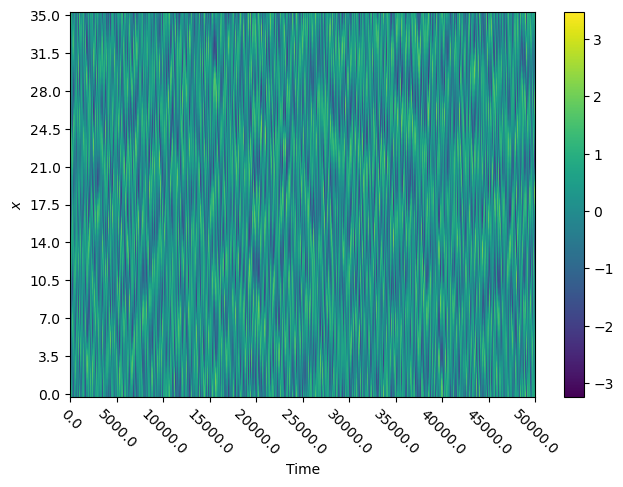

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [5e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
35/35 [==============================] - ETA: 0s - loss: 0.0096 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 6.9657e-04 - tot_time: 0h 0m 49.9s

Epoch 1: val_NMSE improved from inf to 0.00868, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [===================

35/35 [==============================] - ETA: 0s - loss: 0.0077 - mse: 9.2517e-04 - NMSE: 0.0083 - covmat_fro_loss: 6.2565e-04 - tot_time: 0h 3m 39.4s

Epoch 12: val_NMSE improved from 0.00771 to 0.00763, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 452ms/step - loss: 0.0077 - mse: 9.2517e-04 - NMSE: 0.0083 - covmat_fro_loss: 6.2534e-04 - val_loss: 0.0071 - val_mse: 8.4726e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00
Epoch 13/1000
35/35 [==============================] - ETA: 0s - loss: 0.0076 - mse: 9.0876e-04 - NMSE: 0.0082 - covmat_fro_loss: 6.2120e-04 - tot_time: 0h 3m 54.8s

Epoch 13: val_NMSE did not improve from 0.00763
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 454ms/step - loss: 0.0070 - mse: 8.3949e-04 - NMSE: 0.0076 - covmat_fro_loss: 6.0013e-04 - val_loss: 0.0065 - val_mse: 7.6842e-04 - val_NMSE: 0.0069 - val_covmat_fro_loss: 0.0000e+00
Epoch 25/1000
35/35 [==============================] - ETA: 0s - loss: 0.0070 - mse: 8.3306e-04 - NMSE: 0.0075 - covmat_fro_loss: 5.9796e-04 - tot_time: 0h 7m 1.8s

Epoch 25: val_NMSE did not improve from 0.00692
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 435ms/step - loss: 0.0070 - mse: 8.3306e-04 - NMSE: 0.0075 - covmat_fro_loss: 5.9798e-04 - val_loss: 0.0065 - val_mse: 7.7500e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00
Epoch 26/1000
35/35 [================

35/35 [==============================] - ETA: 0s - loss: 0.0065 - mse: 7.7125e-04 - NMSE: 0.0069 - covmat_fro_loss: 5.7704e-04 - tot_time: 0h 10m 6.8s

Epoch 37: val_NMSE improved from 0.00651 to 0.00641, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 458ms/step - loss: 0.0065 - mse: 7.7125e-04 - NMSE: 0.0069 - covmat_fro_loss: 5.7746e-04 - val_loss: 0.0060 - val_mse: 7.1197e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00
Epoch 38/1000
35/35 [==============================] - ETA: 0s - loss: 0.0065 - mse: 7.7282e-04 - NMSE: 0.0070 - covmat_fro_loss: 5.7762e-04 - tot_time: 0h 10m 22.6s

Epoch 38: val_NMSE did not improve from 0.00641
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0062 - mse: 7.2952e-04 - NMSE: 0.0066 - covmat_fro_loss: 5.6359e-04 - val_loss: 0.0060 - val_mse: 7.1055e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00
Epoch 51/1000
35/35 [==============================] - ETA: 0s - loss: 0.0061 - mse: 7.2426e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.6099e-04 - tot_time: 0h 13m 41.3s

Epoch 51: val_NMSE did not improve from 0.00623
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 437ms/step - loss: 0.0061 - mse: 7.2426e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.6127e-04 - val_loss: 0.0060 - val_mse: 7.0979e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00
Epoch 52/1000
35/35 [==============

Epoch 64/1000
35/35 [==============================] - ETA: 0s - loss: 0.0059 - mse: 6.8873e-04 - NMSE: 0.0062 - covmat_fro_loss: 5.4995e-04 - tot_time: 0h 16m 59.1s

Epoch 64: val_NMSE improved from 0.00607 to 0.00595, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 438ms/step - loss: 0.0059 - mse: 6.8873e-04 - NMSE: 0.0062 - covmat_fro_loss: 5.5016e-04 - val_loss: 0.0056 - val_mse: 6.6060e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00
Epoch 65/1000
35/35 [==============================] - ETA: 0s - loss: 0.0058 - mse: 6.8329e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.4639e-04 - tot_time: 0h 17m 14.5s

Epoch 65: val_NMSE did not improve from 0.00595
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS

35/35 [==============================] - ETA: 0s - loss: 0.0056 - mse: 6.5379e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.3542e-04 - tot_time: 0h 20m 18.7s

Epoch 77: val_NMSE improved from 0.00582 to 0.00578, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 460ms/step - loss: 0.0056 - mse: 6.5379e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.3488e-04 - val_loss: 0.0055 - val_mse: 6.4271e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00
Epoch 78/1000
35/35 [==============================] - ETA: 0s - loss: 0.0055 - mse: 6.4547e-04 - NMSE: 0.0058 - covmat_fro_loss: 5.3362e-04 - tot_time: 0h 20m 34.4s

Epoch 78: val_NMSE improved from 0.00578 to 0.00578, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 90/1000
35/35 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.2753e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.2579e-04 - tot_time: 0h 23m 39.3s

Epoch 90: val_NMSE improved from 0.00567 to 0.00565, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 446ms/step - loss: 0.0054 - mse: 6.2753e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.2607e-04 - val_loss: 0.0054 - val_mse: 6.2769e-04 - val_NMSE: 0.0056 - val_covmat_fro_loss: 0.0000e+00
Epoch 91/1000
35/35 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.2643e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.2519e-04 - tot_time: 0h 23m 54.9s

Epoch 91: val_NMSE improved from 0.00565 to 0.00557, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_

Epoch 103/1000
35/35 [==============================] - ETA: 0s - loss: 0.0051 - mse: 5.9626e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.1362e-04 - tot_time: 0h 26m 58.9s

Epoch 103: val_NMSE did not improve from 0.00544
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 435ms/step - loss: 0.0051 - mse: 5.9626e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.1446e-04 - val_loss: 0.0053 - val_mse: 6.0954e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00
Epoch 104/1000
35/35 [==============================] - ETA: 0s - loss: 0.0051 - mse: 5.9860e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.1493e-04 - tot_time: 0h 27m 13.9s

Epoch 104: val_NMSE improved from 0.00544 to 0.00541, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 446ms/step - loss: 0.0050 - mse: 5.8188e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.0755e-04 - val_loss: 0.0050 - val_mse: 5.7865e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00
Epoch 116/1000
35/35 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.8110e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.0683e-04 - tot_time: 0h 30m 19.6s

Epoch 116: val_NMSE did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 432ms/step - loss: 0.0050 - mse: 5.8110e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.0768e-04 - val_loss: 0.0052 - val_mse: 6.0036e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00
Epoch 117/1000
35/35 [===========

Epoch 129/1000
35/35 [==============================] - ETA: 0s - loss: 0.0048 - mse: 5.6000e-04 - NMSE: 0.0050 - covmat_fro_loss: 4.9976e-04 - tot_time: 0h 33m 37.9s

Epoch 129: val_NMSE did not improve from 0.00512
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0048 - mse: 5.6000e-04 - NMSE: 0.0050 - covmat_fro_loss: 4.9978e-04 - val_loss: 0.0050 - val_mse: 5.8089e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00
Epoch 130/1000
35/35 [==============================] - ETA: 0s - loss: 0.0048 - mse: 5.5918e-04 - NMSE: 0.0050 - covmat_fro_loss: 4.9936e-04 - tot_time: 0h 33m 52.8s

Epoch 130: val_NMSE did not improve from 0.00512
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 143/1000
35/35 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.4305e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9164e-04 - tot_time: 0h 37m 9.4s

Epoch 143: val_NMSE did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 433ms/step - loss: 0.0047 - mse: 5.4305e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9129e-04 - val_loss: 0.0049 - val_mse: 5.6288e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00
Epoch 144/1000
35/35 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.4176e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9026e-04 - tot_time: 0h 37m 24.5s

Epoch 144: val_NMSE did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

35/35 [==============================] - ETA: 0s - loss: 0.0046 - mse: 5.2913e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.8540e-04 - tot_time: 0h 40m 26.6s

Epoch 156: val_NMSE did not improve from 0.00492
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 430ms/step - loss: 0.0046 - mse: 5.2913e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.8576e-04 - val_loss: 0.0048 - val_mse: 5.4879e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00
Epoch 157/1000
35/35 [==============================] - ETA: 0s - loss: 0.0045 - mse: 5.2074e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8141e-04 - tot_time: 0h 40m 41.5s

Epoch 157: val_NMSE did not improve from 0.00492
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 426ms/step - l

Epoch 170/1000
35/35 [==============================] - ETA: 0s - loss: 0.0045 - mse: 5.0978e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.7703e-04 - tot_time: 0h 43m 58.4s

Epoch 170: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0045 - mse: 5.0978e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.7787e-04 - val_loss: 0.0047 - val_mse: 5.3624e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00
Epoch 171/1000
35/35 [==============================] - ETA: 0s - loss: 0.0045 - mse: 5.1027e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.7749e-04 - tot_time: 0h 44m 13.5s

Epoch 171: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 184/1000
35/35 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.9485e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7038e-04 - tot_time: 0h 47m 29.7s

Epoch 184: val_NMSE did not improve from 0.00467
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 425ms/step - loss: 0.0043 - mse: 4.9485e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7056e-04 - val_loss: 0.0046 - val_mse: 5.2903e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00
Epoch 185/1000
35/35 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.9959e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7251e-04 - tot_time: 0h 47m 44.7s

Epoch 185: val_NMSE did not improve from 0.00467
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 197/1000
35/35 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.9112e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.6797e-04 - tot_time: 0h 50m 47.5s

Epoch 197: val_NMSE did not improve from 0.00448
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - loss: 0.0043 - mse: 4.9112e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.6793e-04 - val_loss: 0.0045 - val_mse: 5.1741e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00
Epoch 198/1000
35/35 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.8521e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.6591e-04 - tot_time: 0h 51m 2.8s

Epoch 198: val_NMSE did not improve from 0.00448
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

Epoch 211/1000
35/35 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.6829e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5721e-04 - tot_time: 0h 54m 18.1s

Epoch 211: val_NMSE did not improve from 0.00446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 425ms/step - loss: 0.0041 - mse: 4.6829e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5733e-04 - val_loss: 0.0045 - val_mse: 5.1383e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00
Epoch 212/1000
35/35 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.7226e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.5999e-04 - tot_time: 0h 54m 32.9s

Epoch 212: val_NMSE did not improve from 0.00446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 225/1000
35/35 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.5760e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5230e-04 - tot_time: 0h 57m 48.0s

Epoch 225: val_NMSE did not improve from 0.00441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - loss: 0.0041 - mse: 4.5760e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5275e-04 - val_loss: 0.0044 - val_mse: 5.0063e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00
Epoch 226/1000
35/35 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.6521e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5466e-04 - tot_time: 0h 58m 2.9s

Epoch 226: val_NMSE did not improve from 0.00441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 438ms/step - loss: 0.0040 - mse: 4.4722e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4775e-04 - val_loss: 0.0042 - val_mse: 4.8013e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00
Epoch 239/1000
35/35 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.4724e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4703e-04 - tot_time: 1h 1m 19.2s

Epoch 239: val_NMSE did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 434ms/step - loss: 0.0040 - mse: 4.4724e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4661e-04 - val_loss: 0.0043 - val_mse: 4.9234e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00
Epoch 240/1000
35/35 [============

Epoch 252/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.3817e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4329e-04 - tot_time: 1h 4m 33.8s

Epoch 252: val_NMSE did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - loss: 0.0039 - mse: 4.3817e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4383e-04 - val_loss: 0.0043 - val_mse: 4.8485e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00
Epoch 253/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.3903e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4342e-04 - tot_time: 1h 4m 48.6s

Epoch 253: val_NMSE improved from 0.00427 to 0.00427, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

35/35 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.2681e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3703e-04 - tot_time: 1h 7m 48.9s

Epoch 265: val_NMSE did not improve from 0.00420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 428ms/step - loss: 0.0038 - mse: 4.2681e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3702e-04 - val_loss: 0.0042 - val_mse: 4.7071e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00
Epoch 266/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.3335e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4052e-04 - tot_time: 1h 8m 4.1s

Epoch 266: val_NMSE did not improve from 0.00420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 435ms/step - loss

Epoch 279/1000
35/35 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.2554e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3626e-04 - tot_time: 1h 11m 19.3s

Epoch 279: val_NMSE improved from 0.00414 to 0.00413, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 441ms/step - loss: 0.0038 - mse: 4.2554e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3706e-04 - val_loss: 0.0041 - val_mse: 4.5867e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00
Epoch 280/1000
35/35 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.2310e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3584e-04 - tot_time: 1h 11m 35.1s

Epoch 280: val_NMSE improved from 0.00413 to 0.00413, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/sa

Epoch 292/1000
35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.1542e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3122e-04 - tot_time: 1h 14m 37.9s

Epoch 292: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0037 - mse: 4.1542e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3146e-04 - val_loss: 0.0041 - val_mse: 4.5591e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00
Epoch 293/1000
35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.1446e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3098e-04 - tot_time: 1h 14m 52.8s

Epoch 293: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.0299e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2516e-04 - tot_time: 1h 17m 55.6s

Epoch 305: val_NMSE did not improve from 0.00400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 429ms/step - loss: 0.0036 - mse: 4.0299e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2541e-04 - val_loss: 0.0041 - val_mse: 4.5618e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00
Epoch 306/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.0361e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2579e-04 - tot_time: 1h 18m 10.9s

Epoch 306: val_NMSE did not improve from 0.00400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 435ms/step - l

Epoch 319/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.9953e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2299e-04 - tot_time: 1h 21m 28.2s

Epoch 319: val_NMSE did not improve from 0.00397
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 429ms/step - loss: 0.0036 - mse: 3.9953e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2229e-04 - val_loss: 0.0040 - val_mse: 4.4320e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00
Epoch 320/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.9487e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2107e-04 - tot_time: 1h 21m 43.3s

Epoch 320: val_NMSE improved from 0.00397 to 0.00396, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.9160e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1838e-04 - tot_time: 1h 24m 44.5s

Epoch 332: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - loss: 0.0035 - mse: 3.9160e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1855e-04 - val_loss: 0.0040 - val_mse: 4.4317e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00
Epoch 333/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.9578e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2088e-04 - tot_time: 1h 24m 59.3s

Epoch 333: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 422ms/step - l

Epoch 346/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.8809e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1661e-04 - tot_time: 1h 28m 15.5s

Epoch 346: val_NMSE did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 428ms/step - loss: 0.0035 - mse: 3.8809e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1735e-04 - val_loss: 0.0039 - val_mse: 4.3601e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00
Epoch 347/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.8472e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1485e-04 - tot_time: 1h 28m 30.6s

Epoch 347: val_NMSE did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 360/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7736e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1231e-04 - tot_time: 1h 31m 46.3s

Epoch 360: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 429ms/step - loss: 0.0034 - mse: 3.7736e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1315e-04 - val_loss: 0.0038 - val_mse: 4.2841e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00
Epoch 361/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.8408e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1484e-04 - tot_time: 1h 32m 1.3s

Epoch 361: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

Epoch 374/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7211e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0773e-04 - tot_time: 1h 35m 17.8s

Epoch 374: val_NMSE improved from 0.00378 to 0.00373, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 443ms/step - loss: 0.0034 - mse: 3.7211e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0738e-04 - val_loss: 0.0037 - val_mse: 4.1494e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 375/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.7480e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.0954e-04 - tot_time: 1h 35m 33.0s

Epoch 375: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6515e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0436e-04 - tot_time: 1h 38m 33.5s

Epoch 387: val_NMSE did not improve from 0.00368
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 429ms/step - loss: 0.0033 - mse: 3.6515e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0379e-04 - val_loss: 0.0037 - val_mse: 4.1396e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 388/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.6788e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0645e-04 - tot_time: 1h 38m 48.6s

Epoch 388: val_NMSE improved from 0.00368 to 0.00367, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 401/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6168e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0286e-04 - tot_time: 1h 42m 4.7s

Epoch 401: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 432ms/step - loss: 0.0033 - mse: 3.6168e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0218e-04 - val_loss: 0.0037 - val_mse: 4.1081e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 402/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.6651e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0600e-04 - tot_time: 1h 42m 19.7s

Epoch 402: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

Epoch 415/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.5590e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9952e-04 - tot_time: 1h 45m 34.3s

Epoch 415: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 426ms/step - loss: 0.0033 - mse: 3.5590e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9943e-04 - val_loss: 0.0037 - val_mse: 4.0634e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 416/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.5908e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0089e-04 - tot_time: 1h 45m 49.2s

Epoch 416: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 429/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5260e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9753e-04 - tot_time: 1h 49m 4.8s

Epoch 429: val_NMSE improved from 0.00358 to 0.00355, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 442ms/step - loss: 0.0032 - mse: 3.5260e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9754e-04 - val_loss: 0.0036 - val_mse: 3.9432e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 430/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.5008e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9584e-04 - tot_time: 1h 49m 20.2s

Epoch 430: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 443/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.4524e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9357e-04 - tot_time: 1h 52m 35.9s

Epoch 443: val_NMSE did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 430ms/step - loss: 0.0032 - mse: 3.4524e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9354e-04 - val_loss: 0.0036 - val_mse: 3.9431e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 444/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.4520e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9385e-04 - tot_time: 1h 52m 50.8s

Epoch 444: val_NMSE did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 457/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.4403e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9282e-04 - tot_time: 1h 56m 4.8s

Epoch 457: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - loss: 0.0032 - mse: 3.4403e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9218e-04 - val_loss: 0.0036 - val_mse: 3.9912e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 458/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.4081e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9090e-04 - tot_time: 1h 56m 19.8s

Epoch 458: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

Epoch 471/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.3624e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8861e-04 - tot_time: 1h 59m 34.9s

Epoch 471: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 429ms/step - loss: 0.0031 - mse: 3.3624e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8858e-04 - val_loss: 0.0036 - val_mse: 3.9474e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 472/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.3948e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9001e-04 - tot_time: 1h 59m 49.9s

Epoch 472: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 485/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.3054e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8481e-04 - tot_time: 2h 3m 5.1s

Epoch 485: val_NMSE did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 425ms/step - loss: 0.0031 - mse: 3.3054e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8557e-04 - val_loss: 0.0035 - val_mse: 3.8739e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 486/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2876e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8431e-04 - tot_time: 2h 3m 20.3s

Epoch 486: val_NMSE improved from 0.00346 to 0.00345, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/K

35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2736e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8235e-04 - tot_time: 2h 6m 21.0s

Epoch 498: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0030 - mse: 3.2736e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8178e-04 - val_loss: 0.0035 - val_mse: 3.8623e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 499/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2786e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8261e-04 - tot_time: 2h 6m 36.0s

Epoch 499: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - los

Epoch 512/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2651e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8267e-04 - tot_time: 2h 9m 51.8s

Epoch 512: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0030 - mse: 3.2651e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8228e-04 - val_loss: 0.0035 - val_mse: 3.8687e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 513/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.2587e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8271e-04 - tot_time: 2h 10m 6.6s

Epoch 513: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 4

Epoch 526/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1945e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7794e-04 - tot_time: 2h 13m 22.0s

Epoch 526: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 434ms/step - loss: 0.0030 - mse: 3.1945e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7801e-04 - val_loss: 0.0034 - val_mse: 3.7293e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 527/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1588e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7635e-04 - tot_time: 2h 13m 36.9s

Epoch 527: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 540/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1805e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7810e-04 - tot_time: 2h 16m 53.0s

Epoch 540: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 431ms/step - loss: 0.0030 - mse: 3.1805e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7779e-04 - val_loss: 0.0034 - val_mse: 3.6702e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 541/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1278e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7359e-04 - tot_time: 2h 17m 8.3s

Epoch 541: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

Epoch 554/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1497e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7506e-04 - tot_time: 2h 20m 23.9s

Epoch 554: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 430ms/step - loss: 0.0029 - mse: 3.1497e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7479e-04 - val_loss: 0.0035 - val_mse: 3.8093e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 555/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.1269e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7496e-04 - tot_time: 2h 20m 39.0s

Epoch 555: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 568/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0862e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7140e-04 - tot_time: 2h 23m 55.3s

Epoch 568: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 433ms/step - loss: 0.0029 - mse: 3.0862e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7141e-04 - val_loss: 0.0033 - val_mse: 3.6155e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 569/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0604e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.6990e-04 - tot_time: 2h 24m 10.5s

Epoch 569: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 582/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0156e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6730e-04 - tot_time: 2h 27m 28.4s

Epoch 582: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 433ms/step - loss: 0.0028 - mse: 3.0156e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6753e-04 - val_loss: 0.0033 - val_mse: 3.6289e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 583/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0298e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6894e-04 - tot_time: 2h 27m 43.5s

Epoch 583: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 596/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 3.0009e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6667e-04 - tot_time: 2h 30m 60.0s

Epoch 596: val_NMSE did not improve from 0.00317
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 434ms/step - loss: 0.0028 - mse: 3.0009e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6656e-04 - val_loss: 0.0033 - val_mse: 3.5737e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 597/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.0381e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6844e-04 - tot_time: 2h 31m 14.9s

Epoch 597: val_NMSE did not improve from 0.00317
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 609/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9749e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6422e-04 - tot_time: 2h 34m 18.1s

Epoch 609: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 427ms/step - loss: 0.0028 - mse: 2.9749e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6451e-04 - val_loss: 0.0032 - val_mse: 3.5090e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 610/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9864e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6511e-04 - tot_time: 2h 34m 33.1s

Epoch 610: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s

Epoch 623/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9525e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6359e-04 - tot_time: 2h 37m 50.1s

Epoch 623: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 430ms/step - loss: 0.0028 - mse: 2.9525e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6352e-04 - val_loss: 0.0033 - val_mse: 3.5271e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 624/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9168e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6153e-04 - tot_time: 2h 38m 5.3s

Epoch 624: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 

Epoch 637/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9298e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6181e-04 - tot_time: 2h 41m 21.9s

Epoch 637: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 439ms/step - loss: 0.0028 - mse: 2.9298e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6187e-04 - val_loss: 0.0033 - val_mse: 3.5529e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 638/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.9318e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6169e-04 - tot_time: 2h 41m 37.4s

Epoch 638: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 651/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8688e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5840e-04 - tot_time: 2h 45m 2.8s

Epoch 651: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 448ms/step - loss: 0.0027 - mse: 2.8688e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5876e-04 - val_loss: 0.0032 - val_mse: 3.4225e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 652/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.9021e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5959e-04 - tot_time: 2h 45m 18.5s

Epoch 652: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 

Epoch 665/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8773e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5865e-04 - tot_time: 2h 48m 43.0s

Epoch 665: val_NMSE did not improve from 0.00303
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 450ms/step - loss: 0.0027 - mse: 2.8773e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5880e-04 - val_loss: 0.0032 - val_mse: 3.5068e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 666/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8510e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5651e-04 - tot_time: 2h 48m 58.8s

Epoch 666: val_NMSE improved from 0.00303 to 0.00302, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 465ms/step - loss: 0.0027 - mse: 2.8196e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5511e-04 - val_loss: 0.0031 - val_mse: 3.3417e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 679/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.8498e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5653e-04 - tot_time: 2h 52m 25.1s

Epoch 679: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 451ms/step - loss: 0.0027 - mse: 2.8498e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5643e-04 - val_loss: 0.0032 - val_mse: 3.4251e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 680/1000
35/35 [===========

35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7796e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5272e-04 - tot_time: 2h 55m 50.0s

Epoch 692: val_NMSE improved from 0.00301 to 0.00300, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 457ms/step - loss: 0.0026 - mse: 2.7796e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5244e-04 - val_loss: 0.0031 - val_mse: 3.3371e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 693/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7920e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5344e-04 - tot_time: 2h 56m 6.1s

Epoch 693: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7938e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5280e-04 - tot_time: 2h 59m 16.0s

Epoch 705: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 451ms/step - loss: 0.0027 - mse: 2.7938e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5302e-04 - val_loss: 0.0031 - val_mse: 3.2969e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 706/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7620e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5126e-04 - tot_time: 2h 59m 31.9s

Epoch 706: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 452ms/step - l

Epoch 719/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7274e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.4836e-04 - tot_time: 3h 2m 56.6s

Epoch 719: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 452ms/step - loss: 0.0026 - mse: 2.7274e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.4843e-04 - val_loss: 0.0032 - val_mse: 3.4155e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 720/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7276e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.4921e-04 - tot_time: 3h 3m 12.5s

Epoch 720: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 4

Epoch 733/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7095e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4771e-04 - tot_time: 3h 6m 38.2s

Epoch 733: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 453ms/step - loss: 0.0026 - mse: 2.7095e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4759e-04 - val_loss: 0.0031 - val_mse: 3.2775e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 734/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7110e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4727e-04 - tot_time: 3h 6m 54.1s

Epoch 734: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 4

Epoch 747/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6966e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4643e-04 - tot_time: 3h 10m 19.4s

Epoch 747: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 452ms/step - loss: 0.0026 - mse: 2.6966e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4635e-04 - val_loss: 0.0031 - val_mse: 3.3157e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 748/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.7152e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4794e-04 - tot_time: 3h 10m 35.2s

Epoch 748: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 761/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6925e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4681e-04 - tot_time: 3h 14m 0.9s

Epoch 761: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 446ms/step - loss: 0.0026 - mse: 2.6925e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4678e-04 - val_loss: 0.0031 - val_mse: 3.2979e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 762/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6553e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4457e-04 - tot_time: 3h 14m 16.8s

Epoch 762: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 

Epoch 775/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6403e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4251e-04 - tot_time: 3h 17m 42.2s

Epoch 775: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 454ms/step - loss: 0.0025 - mse: 2.6403e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4276e-04 - val_loss: 0.0031 - val_mse: 3.2788e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 776/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6616e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4412e-04 - tot_time: 3h 17m 58.3s

Epoch 776: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 789/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6133e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4139e-04 - tot_time: 3h 21m 25.5s

Epoch 789: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 455ms/step - loss: 0.0025 - mse: 2.6133e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4129e-04 - val_loss: 0.0030 - val_mse: 3.2118e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 790/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.6545e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4401e-04 - tot_time: 3h 21m 41.1s

Epoch 790: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 803/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5765e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3884e-04 - tot_time: 3h 25m 6.2s

Epoch 803: val_NMSE improved from 0.00283 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 462ms/step - loss: 0.0025 - mse: 2.5765e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3825e-04 - val_loss: 0.0029 - val_mse: 3.1421e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 804/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5967e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3959e-04 - tot_time: 3h 25m 22.5s

Epoch 804: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5947e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3932e-04 - tot_time: 3h 28m 32.7s

Epoch 816: val_NMSE improved from 0.00283 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 467ms/step - loss: 0.0025 - mse: 2.5947e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3911e-04 - val_loss: 0.0029 - val_mse: 3.1378e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 817/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5685e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3766e-04 - tot_time: 3h 28m 48.8s

Epoch 817: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5485e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3648e-04 - tot_time: 3h 31m 55.1s

Epoch 829: val_NMSE did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 435ms/step - loss: 0.0025 - mse: 2.5485e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3664e-04 - val_loss: 0.0030 - val_mse: 3.1704e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 830/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5897e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3914e-04 - tot_time: 3h 32m 10.4s

Epoch 830: val_NMSE did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 437ms/step - l

Epoch 843/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5398e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3559e-04 - tot_time: 3h 35m 31.8s

Epoch 843: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 451ms/step - loss: 0.0025 - mse: 2.5398e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3540e-04 - val_loss: 0.0030 - val_mse: 3.1730e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 844/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5321e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3559e-04 - tot_time: 3h 35m 47.8s

Epoch 844: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 857/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.5501e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3683e-04 - tot_time: 3h 39m 13.2s

Epoch 857: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 454ms/step - loss: 0.0025 - mse: 2.5501e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3721e-04 - val_loss: 0.0029 - val_mse: 3.0964e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 858/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5088e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3373e-04 - tot_time: 3h 39m 29.0s

Epoch 858: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 871/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4911e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3263e-04 - tot_time: 3h 42m 54.7s

Epoch 871: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 448ms/step - loss: 0.0024 - mse: 2.4911e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3293e-04 - val_loss: 0.0029 - val_mse: 3.1257e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 872/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.5069e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3410e-04 - tot_time: 3h 43m 10.4s

Epoch 872: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 885/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4826e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3200e-04 - tot_time: 3h 46m 34.5s

Epoch 885: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 452ms/step - loss: 0.0024 - mse: 2.4826e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3169e-04 - val_loss: 0.0029 - val_mse: 3.0444e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 886/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4826e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3217e-04 - tot_time: 3h 46m 50.1s

Epoch 886: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 899/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4949e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3202e-04 - tot_time: 3h 50m 15.2s

Epoch 899: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 451ms/step - loss: 0.0024 - mse: 2.4949e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3180e-04 - val_loss: 0.0028 - val_mse: 2.9888e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 900/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4329e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2826e-04 - tot_time: 3h 50m 30.9s

Epoch 900: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 913/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4586e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3058e-04 - tot_time: 3h 53m 56.0s

Epoch 913: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 448ms/step - loss: 0.0024 - mse: 2.4586e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3095e-04 - val_loss: 0.0029 - val_mse: 3.0862e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 914/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4573e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3051e-04 - tot_time: 3h 54m 11.8s

Epoch 914: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s

Epoch 927/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4253e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2745e-04 - tot_time: 3h 57m 36.4s

Epoch 927: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 449ms/step - loss: 0.0024 - mse: 2.4253e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2725e-04 - val_loss: 0.0028 - val_mse: 2.9944e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 928/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4218e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2712e-04 - tot_time: 3h 57m 52.2s

Epoch 928: val_NMSE improved from 0.00268 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 941/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4138e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2728e-04 - tot_time: 4h 1m 17.6s

Epoch 941: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 455ms/step - loss: 0.0024 - mse: 2.4138e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2748e-04 - val_loss: 0.0028 - val_mse: 3.0077e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 942/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4085e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2628e-04 - tot_time: 4h 1m 33.3s

Epoch 942: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 4

Epoch 955/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.4126e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2715e-04 - tot_time: 4h 4m 57.9s

Epoch 955: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 445ms/step - loss: 0.0024 - mse: 2.4126e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2753e-04 - val_loss: 0.0028 - val_mse: 2.9281e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 956/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3741e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2459e-04 - tot_time: 4h 5m 13.2s

Epoch 956: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 4

Epoch 969/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3579e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2318e-04 - tot_time: 4h 8m 36.6s

Epoch 969: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 15s 438ms/step - loss: 0.0023 - mse: 2.3579e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2268e-04 - val_loss: 0.0028 - val_mse: 2.9540e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 970/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3561e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2313e-04 - tot_time: 4h 8m 52.3s

Epoch 970: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 4

35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3606e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2379e-04 - tot_time: 4h 12m 2.4s

Epoch 982: val_NMSE improved from 0.00262 to 0.00261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 461ms/step - loss: 0.0023 - mse: 2.3606e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2375e-04 - val_loss: 0.0028 - val_mse: 2.9018e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 983/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3284e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2141e-04 - tot_time: 4h 12m 18.3s

Epoch 983: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3464e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2203e-04 - tot_time: 4h 15m 26.9s

Epoch 995: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 447ms/step - loss: 0.0023 - mse: 2.3464e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2180e-04 - val_loss: 0.0027 - val_mse: 2.8731e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 996/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.3281e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2129e-04 - tot_time: 4h 15m 42.7s

Epoch 996: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 16s 453ms/step - l

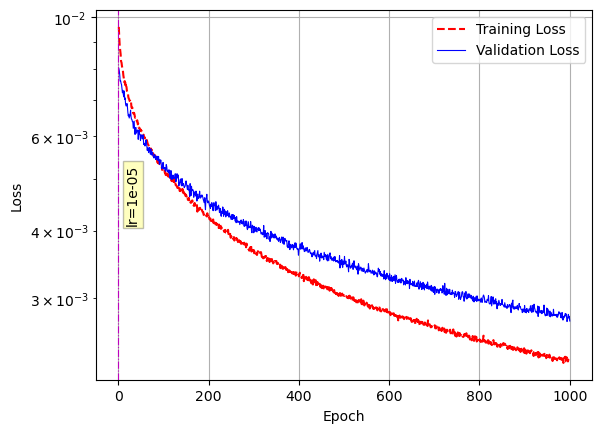



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
29/29 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0051 - NMSE: 0.0463 - covmat_fro_loss: 0.0026 - tot_time: 0h 1m 46.4s

Epoch 1: val_NMSE improved from inf to 0.01766, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [=======================

Epoch 14/1000
29/29 [==============================] - ETA: 0s - loss: 0.0249 - mse: 0.0043 - NMSE: 0.0387 - covmat_fro_loss: 0.0023 - tot_time: 0h 5m 32.7s

Epoch 14: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 597ms/step - loss: 0.0249 - mse: 0.0043 - NMSE: 0.0387 - covmat_fro_loss: 0.0023 - val_loss: 0.0143 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00
Epoch 15/1000
29/29 [==============================] - ETA: 0s - loss: 0.0255 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 0.0024 - tot_time: 0h 5m 50.1s

Epoch 15: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 602ms/step - loss: 0.0255 - mse: 

Epoch 29/1000
29/29 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0023 - tot_time: 0h 9m 50.5s

Epoch 29: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 600ms/step - loss: 0.0245 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0023 - val_loss: 0.0153 - val_mse: 0.0025 - val_NMSE: 0.0229 - val_covmat_fro_loss: 0.0000e+00
Epoch 30/1000
29/29 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0042 - NMSE: 0.0380 - covmat_fro_loss: 0.0023 - tot_time: 0h 10m 7.9s

Epoch 30: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 599ms/step - loss: 0.0245 - mse: 

Epoch 44/1000
29/29 [==============================] - ETA: 0s - loss: 0.0241 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0023 - tot_time: 0h 14m 0.8s

Epoch 44: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 575ms/step - loss: 0.0241 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0023 - val_loss: 0.0150 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_covmat_fro_loss: 0.0000e+00
Epoch 45/1000
29/29 [==============================] - ETA: 0s - loss: 0.0238 - mse: 0.0041 - NMSE: 0.0370 - covmat_fro_loss: 0.0023 - tot_time: 0h 14m 17.3s

Epoch 45: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 569ms/step - loss: 0.0238 - mse:

Epoch 59/1000
29/29 [==============================] - ETA: 0s - loss: 0.0234 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0022 - tot_time: 0h 18m 9.1s

Epoch 59: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 573ms/step - loss: 0.0234 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0022 - val_loss: 0.0152 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_covmat_fro_loss: 0.0000e+00
Epoch 60/1000
29/29 [==============================] - ETA: 0s - loss: 0.0238 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0023 - tot_time: 0h 18m 25.7s

Epoch 60: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 574ms/step - loss: 0.0238 - mse:

Epoch 74/1000
29/29 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0039 - NMSE: 0.0354 - covmat_fro_loss: 0.0022 - tot_time: 0h 22m 18.0s

Epoch 74: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 16s 569ms/step - loss: 0.0228 - mse: 0.0039 - NMSE: 0.0354 - covmat_fro_loss: 0.0022 - val_loss: 0.0155 - val_mse: 0.0026 - val_NMSE: 0.0231 - val_covmat_fro_loss: 0.0000e+00
Epoch 75/1000
29/29 [==============================] - ETA: 0s - loss: 0.0235 - mse: 0.0041 - NMSE: 0.0365 - covmat_fro_loss: 0.0023 - tot_time: 0h 22m 34.6s

Epoch 75: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 573ms/step - loss: 0.0235 - mse

Epoch 89/1000
29/29 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0039 - NMSE: 0.0347 - covmat_fro_loss: 0.0022 - tot_time: 0h 26m 27.8s

Epoch 89: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 572ms/step - loss: 0.0224 - mse: 0.0039 - NMSE: 0.0347 - covmat_fro_loss: 0.0022 - val_loss: 0.0149 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00
Epoch 90/1000
29/29 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0039 - NMSE: 0.0353 - covmat_fro_loss: 0.0022 - tot_time: 0h 26m 44.4s

Epoch 90: val_NMSE did not improve from 0.01705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 17s 574ms/step - loss: 0.0228 - mse

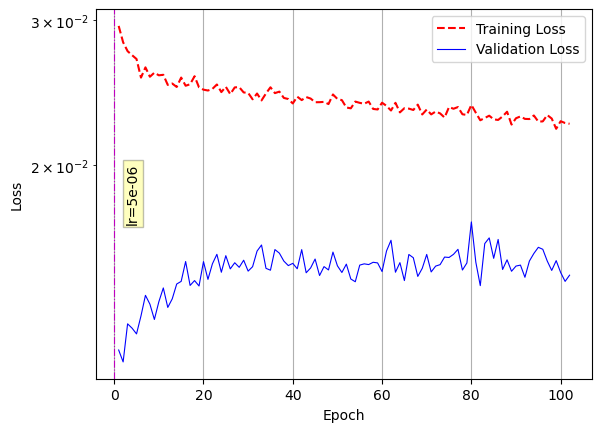



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 0.0934 - mse: 0.0225 - NMSE: 0.2029 - covmat_fro_loss: 0.0060 - tot_time: 0h 3m 11.5s

Epoch 1: val_NMSE improved from inf to 0.06992, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [=======================

24/24 [==============================] - ETA: 0s - loss: 0.0867 - mse: 0.0209 - NMSE: 0.1880 - covmat_fro_loss: 0.0058 - tot_time: 0h 7m 0.4s

Epoch 14: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 733ms/step - loss: 0.0867 - mse: 0.0209 - NMSE: 0.1880 - covmat_fro_loss: 0.0058 - val_loss: 0.0376 - val_mse: 0.0087 - val_NMSE: 0.0786 - val_covmat_fro_loss: 0.0000e+00
Epoch 15/1000
24/24 [==============================] - ETA: 0s - loss: 0.0869 - mse: 0.0209 - NMSE: 0.1884 - covmat_fro_loss: 0.0057 - tot_time: 0h 7m 18.1s

Epoch 15: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 739ms/step - loss: 0.0869 - mse: 0.0209 - NMSE: 

Epoch 29/1000
24/24 [==============================] - ETA: 0s - loss: 0.0858 - mse: 0.0206 - NMSE: 0.1858 - covmat_fro_loss: 0.0057 - tot_time: 0h 11m 24.8s

Epoch 29: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 736ms/step - loss: 0.0858 - mse: 0.0206 - NMSE: 0.1858 - covmat_fro_loss: 0.0057 - val_loss: 0.0407 - val_mse: 0.0095 - val_NMSE: 0.0852 - val_covmat_fro_loss: 0.0000e+00
Epoch 30/1000
24/24 [==============================] - ETA: 0s - loss: 0.0866 - mse: 0.0208 - NMSE: 0.1875 - covmat_fro_loss: 0.0057 - tot_time: 0h 11m 42.2s

Epoch 30: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 17s 729ms/step - loss: 0.0866 - mse

Epoch 44/1000
24/24 [==============================] - ETA: 0s - loss: 0.0844 - mse: 0.0203 - NMSE: 0.1828 - covmat_fro_loss: 0.0056 - tot_time: 0h 15m 48.5s

Epoch 44: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 734ms/step - loss: 0.0844 - mse: 0.0203 - NMSE: 0.1828 - covmat_fro_loss: 0.0056 - val_loss: 0.0454 - val_mse: 0.0106 - val_NMSE: 0.0952 - val_covmat_fro_loss: 0.0000e+00
Epoch 45/1000
24/24 [==============================] - ETA: 0s - loss: 0.0857 - mse: 0.0206 - NMSE: 0.1856 - covmat_fro_loss: 0.0057 - tot_time: 0h 16m 6.1s

Epoch 45: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 734ms/step - loss: 0.0857 - mse:

Epoch 59/1000
24/24 [==============================] - ETA: 0s - loss: 0.0840 - mse: 0.0202 - NMSE: 0.1817 - covmat_fro_loss: 0.0056 - tot_time: 0h 20m 12.3s

Epoch 59: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 17s 726ms/step - loss: 0.0840 - mse: 0.0202 - NMSE: 0.1817 - covmat_fro_loss: 0.0056 - val_loss: 0.0477 - val_mse: 0.0111 - val_NMSE: 0.1003 - val_covmat_fro_loss: 0.0000e+00
Epoch 60/1000
24/24 [==============================] - ETA: 0s - loss: 0.0853 - mse: 0.0205 - NMSE: 0.1847 - covmat_fro_loss: 0.0056 - tot_time: 0h 20m 30.1s

Epoch 60: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 741ms/step - loss: 0.0853 - mse

Epoch 74/1000
24/24 [==============================] - ETA: 0s - loss: 0.0808 - mse: 0.0194 - NMSE: 0.1747 - covmat_fro_loss: 0.0055 - tot_time: 0h 24m 37.4s

Epoch 74: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 737ms/step - loss: 0.0808 - mse: 0.0194 - NMSE: 0.1747 - covmat_fro_loss: 0.0055 - val_loss: 0.0492 - val_mse: 0.0115 - val_NMSE: 0.1033 - val_covmat_fro_loss: 0.0000e+00
Epoch 75/1000
24/24 [==============================] - ETA: 0s - loss: 0.0835 - mse: 0.0201 - NMSE: 0.1807 - covmat_fro_loss: 0.0056 - tot_time: 0h 24m 54.9s

Epoch 75: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 732ms/step - loss: 0.0835 - mse

Epoch 89/1000
24/24 [==============================] - ETA: 0s - loss: 0.0814 - mse: 0.0196 - NMSE: 0.1760 - covmat_fro_loss: 0.0055 - tot_time: 0h 29m 0.3s

Epoch 89: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 731ms/step - loss: 0.0814 - mse: 0.0196 - NMSE: 0.1760 - covmat_fro_loss: 0.0055 - val_loss: 0.0519 - val_mse: 0.0121 - val_NMSE: 0.1093 - val_covmat_fro_loss: 0.0000e+00
Epoch 90/1000
24/24 [==============================] - ETA: 0s - loss: 0.0829 - mse: 0.0199 - NMSE: 0.1791 - covmat_fro_loss: 0.0056 - tot_time: 0h 29m 17.9s

Epoch 90: val_NMSE did not improve from 0.06992
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_007/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 18s 735ms/step - loss: 0.0829 - mse:

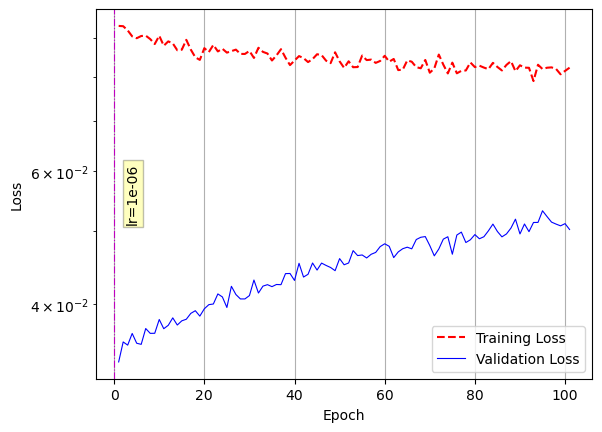

In [21]:
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_GRU,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=stateful,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)

In [22]:
### Training the combined AE-RNN
